# The Logistic Map

In this notebook we take a look at the logistic map as an example of a discrete-time
dynamical system that can exhibit chaotic behaviour. We implement the system, look at fixed points and their stability,
and some example (chaotic) trajectories. Finally, we characterize the logistic map by means of a bifurcation plot and
the Ljapunov exponent.

So let's get started. First, we need some imports.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation

from src.utils.plotting import init_plot_style

%matplotlib inline

# initialize our global plot style
init_plot_style()

Below we implement the logistic map, it's derivative, and a convenience function to compute trajectories for given
initial states.

In [7]:
class LogisticMap:
    """
    Implementation of the logistic map.
    """

    def __init__(self, r: float):
        """
        Parameters
        ----------
        r : float
            Control parameter of the logistic map.
        """
        self.r = r

    def __call__(self, x: np.ndarray):
        """ The logistic map.

        Parameters
        ----------
        x : numpy.ndarray
            State or batch of states

        Returns
        ------
        numpy.ndarray
            The logistic map applied to the input state(s)
        """
        return self.r * x * (1. - x)

    def derivative(self, x: np.ndarray):
        """ Derivative of the logistic map evaluated at the input state(s).

        Parameters
        ----------
        x : numpy.ndarray
            State or batch of states

        Returns
        ------
         numpy.ndarray
            The derivative(s) evaluated at x
        """
        return self.r * (1. - 2. * x)

    def compute_trajectory(self, x0: np.ndarray, n_max: int):
        """ Computes the system trajectory for a given initial state.

        Parameters
        ----------
        x0 : numpy.ndarray
            Initial state(s)
        n_max : int
            Trajectory length

        Returns
        ------
         numpy.ndarray
            The trajectories (sequence of states for each inital state)
        """
        if np.isscalar(x0):
            x0 = np.array(x0)

        x0 = x0.reshape((-1,))

        trajectories = np.zeros((len(x0), n_max))
        trajectories[:, 0] = x0
        for n in range(1, n_max):
            trajectories[:, n] = self(trajectories[:, n - 1])

        return trajectories if len(x0) > 1 else trajectories.squeeze(0)



We can now instantiate our system with the desired parameters and
look at an example trajectory.

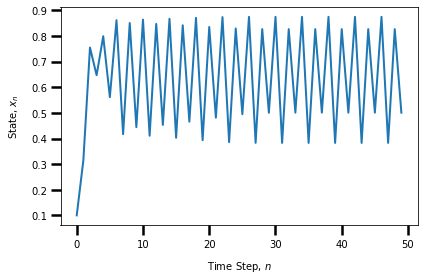

In [24]:
%matplotlib inline
# parameters
r = 3.5
x0 = 0.1

# instantiate logistic map +  compute trajectory
logmap = LogisticMap(r=r)
trajectory = logmap.compute_trajectory(x0, n_max=500)

# plot trajectory as a function of time
plt.close('all')
plt.figure()
plt.plot(trajectory[:50])
plt.xlabel('Time Step, $n$')
plt.ylabel('State, $x_n$')
plt.tight_layout()

Next, we plot our logistic map over the state space including fixed points. To get an intuition of the logistic map's
behaviour, we animate the trajectory in this state-space plot.

In [25]:
%matplotlib 

# compute map over certain sub-space
x_fp2 = 1. - 1. / r
x_min = np.minimum(-0.05, x_fp2 - 0.05)
support = np.linspace(x_min, 1.05, 100)
forward_map = logmap(support)

# plot map with fixed points
fig = plt.figure()
plt.plot(support, forward_map, label='Logistic Map')
plt.plot(support, support, 'k--', label=r'$x_n = x_{n+1}$')
plt.plot(0, 0, 'o', label=f'Fix point $x_1^*={0}$')
plt.plot(x_fp2, x_fp2, 'o', label=f'Fix point $x_2^*={x_fp2:.1f}$')
plt.xlabel(r'State, $x_n$')
plt.ylabel(r'Next state, $x_{n+1}$')
plt.legend()
plt.grid()
plt.tight_layout()

# animation parameters
frames = 100
t_step = 200  # stepping time in ms
repeat_delay = 1000  # delay between repetitions

# define animation step
line, = plt.plot([], [], 'o-', lw=2)


def animation_step(i):
    j = int(i / 2)
    if i % 2 == 0:
        line.set_data([trajectory[j], trajectory[j]], [trajectory[j], trajectory[j + 1]])

    else:
        line.set_data([trajectory[j], trajectory[j + 1]], [trajectory[j + 1], trajectory[j + 1]])
    # fig.canvas.draw()
    return line


# animate
anim = animation.FuncAnimation(fig, animation_step, frames=frames, interval=t_step, repeat_delay=repeat_delay)


Using matplotlib backend: Qt5Agg


To gain insight into the behaviour of the logistic map in dependence of the control parameter $r$ we can create a
bifurcation plot. To do so we generate a couple of sample trajectories with random initial states and record their
steady states. Additionally, we can approximate the Ljapunov exponent as a function of the control parameter and
compare it to the bifurcation diagram.

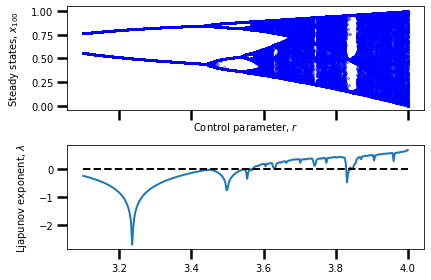

In [28]:
%matplotlib inline

# parameters
r_sweep = np.linspace(3.1, 4., 300)
num_trajectories = 200
n_max = 100

# create the logistic maps + sample trajectories
logmaps = [LogisticMap(r) for r in r_sweep]
initial_states = np.random.uniform(0, 1, num_trajectories)
trajectories = np.array([lm.compute_trajectory(initial_states, n_max) for lm in logmaps])

# extract steady states + compute Ljapunov exponents
steady_states = trajectories[:, :, -1]
derivatives = np.array([lm.derivative(traj) for lm, traj in zip(logmaps, trajectories)])
ljpnv_exp = np.mean(np.sum(np.log(np.abs(derivatives)), axis=2), axis=1) / n_max

plt.close('all')
fix, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(r_sweep, steady_states, 'b.', markersize=1)
ax[0].set_xlabel(r'Control parameter, $r$')
ax[0].set_ylabel(r'Steady states, $x_{%d}$' % n_max)

ax[1].plot(r_sweep, ljpnv_exp)
ax[1].plot([r_sweep[0], r_sweep[-1]], [0, 0], 'k--')
ax[1].set_ylabel(r'Ljapunov exponent, $\lambda$')
plt.tight_layout()


Finally, we look at how fast two trajectories diverge when their initial states are very close and the logistic map
is in chaotic mode. We will also illustrate how this relates to the Ljapunov exponent.

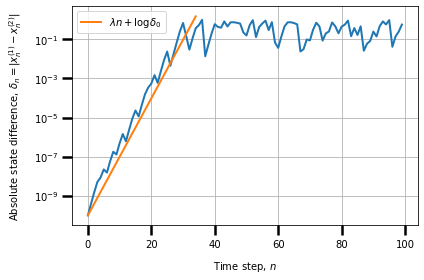

In [29]:
r = 4.
x0 = np.random.uniform(0, 1)
delta0 = 1e-10
n_max = 100
logmap = LogisticMap(r)
deltas = np.abs(logmap.compute_trajectory(x0, n_max) - logmap.compute_trajectory(x0 + delta0, n_max))

ljpnv_line = np.exp(ljpnv_exp[-1] * np.arange(0, 35)) * delta0

plt.close('all')
plt.figure()
plt.plot(deltas)
plt.plot(ljpnv_line, label=r'$\lambda n + \log \delta_0$')
plt.semilogy()
plt.xlabel(r'Time step, $n$')
plt.ylabel(r'Absolute state difference, $\delta_n = |x^{(1)}_n - x^{(2)}_n|$')
plt.legend()
plt.grid()
plt.tight_layout()